# Data Explore

In [1]:
%load_ext autoreload
%autoreload 2

import src.data_proc as data_proc

import numpy as np
import pandas as pd
import sys
import os
import gc
import random
pd.options.display.max_columns = None
pd.options.mode.chained_assignment = None
pd.options.display.float_format

from sklearn.model_selection import train_test_split

from catboost import CatBoostRegressor, Pool

import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.pylab as pylab
import seaborn as sns
%matplotlib inline
mpl.style.use( 'ggplot' )
sns.set_style( 'white' )
pylab.rcParams[ 'figure.figsize' ] = 8 , 6

In [2]:
%%time

prop = data_proc.load_properties_data("data/properties_2016.csv")
print("Number of properties: {}".format(len(prop)))
print("Number of property features: {}".format(len(prop.columns)-1))

# Load in 2016 training data (with logerror labels)
train_2016 = data_proc.load_training_data("data/train_2016_v2.csv")
print("Number of 2016 transaction records: {}".format(len(train_2016)))
print("\n", train_2016.head())


# Load in 2017 training data (with logerror labels)
train_2017 = data_proc.load_training_data("data/train_2017.csv")
print("Number of 2017 transaction records: {}".format(len(train_2017)))
print("\n", train_2017.head())


Number of properties: 2985217
Number of property features: 57
Number of 2016 transaction records: 90275

    parcelid  logerror transactiondate
0  11016594    0.0276      2016-01-01
1  14366692   -0.1684      2016-01-01
2  12098116   -0.0040      2016-01-01
3  12643413    0.0218      2016-01-02
4  14432541   -0.0050      2016-01-02
Number of 2017 transaction records: 77613

    parcelid  logerror transactiondate
0  14297519  0.025595      2017-01-01
1  17052889  0.055619      2017-01-01
2  14186244  0.005383      2017-01-01
3  12177905 -0.103410      2017-01-01
4  10887214  0.006940      2017-01-01
Wall time: 7.85 s


In [3]:
%%time
# Rename & retype the feature columns; also unify representations of missing values
data_proc.rename_columns(prop)
data_proc.retype_columns(prop)

Wall time: 7.59 s


In [4]:
# Join the training data with the property table
train_2016 = train_2016.merge(how='left', right=prop, on='parcelid')
train_2016.head(10)

,parcelid,logerror,transactiondate,cooling_id,architecture_style_id,basement_sqft,bathroom_cnt,bedroom_cnt,framing_id,quality_id,bathroom_cnt_calc,deck_id,floor1_sqft,finished_area_sqft_calc,finished_area_sqft,perimeter_area,total_area,floor1_sqft_unk,base_total_area,fips,fireplace_cnt,bathroom_full_cnt,garage_cnt,garage_sqft,spa_flag,heating_id,latitude,longitude,lot_sqft,pool_cnt,pool_total_size,pool_unk_1,pool_unk_2,pool_unk_3,county_landuse_code,landuse_type_id,zoning_description,census_1,city_id,county_id,neighborhood_id,region_zip,room_cnt,story_id,bathroom_small_cnt,construction_id,unit_cnt,patio_sqft,storage_sqft,year_built,story_cnt,fireplace_flag,tax_structure,tax_parcel,tax_year,tax_land,tax_property,tax_overdue_flag,tax_overdue_year,census_2
0,11016594,0.0276,2016-01-01,0,-1,NaN,2.0,3.0,-1,4.0,2.0,NaN,NaN,1684.0,1684.0,NaN,NaN,NaN,NaN,0,NaN,2.0,NaN,NaN,NaN,1,34280992.0,-118488536.0,7528.0,NaN,NaN,NaN,NaN,NaN,0100,230,LARS,60371068.0,12447.0,1815,31817.0,96370.0,0.0,NaN,NaN,-1,1.0,NaN,NaN,1959.0,NaN,NaN,122754.0,360170.0,2015.0,237416.0,6735.879883,NaN,NaN,6.037107e+13
1,14366692,-0.1684,2016-01-01,-1,-1,NaN,3.5,4.0,-1,NaN,3.5,NaN,NaN,2263.0,2263.0,NaN,NaN,NaN,NaN,22,NaN,3.0,2.0,468.0,NaN,-1,33668120.0,-117677552.0,3643.0,NaN,NaN,NaN,NaN,NaN,1,230,NaN,60590524.0,32380.0,0,NaN,96962.0,0.0,NaN,1.0,-1,NaN,NaN,NaN,2014.0,NaN,NaN,346458.0,585529.0,2015.0,239071.0,10153.019531,NaN,NaN,NaN
2,12098116,-0.0040,2016-01-01,0,-1,NaN,3.0,2.0,-1,4.0,3.0,NaN,NaN,2217.0,2217.0,NaN,NaN,NaN,NaN,0,NaN,3.0,NaN,NaN,NaN,1,34136312.0,-118175032.0,11423.0,NaN,NaN,NaN,NaN,NaN,0100,230,PSR6,60374640.0,47019.0,1815,275411.0,96293.0,0.0,NaN,NaN,-1,1.0,NaN,NaN,1940.0,NaN,NaN,61994.0,119906.0,2015.0,57912.0,11484.480469,NaN,NaN,6.037464e+13
3,12643413,0.0218,2016-01-02,0,-1,NaN,2.0,2.0,-1,4.0,2.0,NaN,NaN,839.0,839.0,NaN,NaN,NaN,NaN,0,NaN,2.0,NaN,NaN,NaN,1,33755800.0,-118309000.0,70859.0,NaN,NaN,NaN,NaN,NaN,010C,235,LAR3,60372964.0,12447.0,1815,54300.0,96222.0,0.0,NaN,NaN,-1,1.0,NaN,NaN,1987.0,NaN,NaN,171518.0,244880.0,2015.0,73362.0,3048.739990,NaN,NaN,6.037296e+13
4,14432541,-0.0050,2016-01-02,-1,-1,NaN,2.5,4.0,-1,NaN,2.5,NaN,NaN,2283.0,2283.0,NaN,NaN,NaN,NaN,22,NaN,2.0,2.0,598.0,NaN,-1,33485644.0,-117700232.0,6000.0,1.0,NaN,NaN,NaN,1.0,122,230,NaN,60590424.0,17686.0,0,NaN,96961.0,8.0,NaN,1.0,-1,NaN,NaN,NaN,1981.0,2.0,NaN,169574.0,434551.0,2015.0,264977.0,5488.959961,NaN,NaN,6.059042e+13
5,11509835,-0.2705,2016-01-02,0,-1,NaN,4.0,4.0,-1,1.0,4.0,NaN,NaN,3067.0,3067.0,NaN,NaN,NaN,NaN,0,NaN,4.0,NaN,NaN,NaN,1,33870088.0,-118402768.0,2708.0,NaN,NaN,NaN,NaN,NaN,0100,230,HBR3YY,60376212.0,29712.0,1815,NaN,96109.0,0.0,NaN,NaN,-1,1.0,NaN,NaN,1982.0,NaN,NaN,880650.0,2447951.0,2015.0,1567301.0,27126.570312,NaN,NaN,6.037621e+13
6,12286022,0.0440,2016-01-02,-1,-1,NaN,1.0,2.0,-1,7.0,1.0,NaN,NaN,1297.0,1297.0,NaN,NaN,NaN,NaN,0,NaN,1.0,NaN,NaN,NaN,6,33899476.0,-118212720.0,6677.0,NaN,NaN,NaN,NaN,NaN,0100,230,CORH*,60375416.0,24174.0,1815,NaN,96091.0,0.0,NaN,NaN,-1,1.0,NaN,NaN,1939.0,NaN,NaN,64549.0,111521.0,2015.0,46972.0,2304.969971,NaN,NaN,6.037542e+13
7,17177301,0.1638,2016-01-02,-1,-1,NaN,2.5,3.0,-1,NaN,2.5,NaN,853.0,1763.0,1763.0,NaN,NaN,853.0,NaN,74,1.0,2.0,2.0,0.0,NaN,-1,34207204.0,-119165592.0,NaN,NaN,NaN,NaN,NaN,NaN,1129,235,NaN,61110032.0,13150.0,775,NaN,97101.0,6.0,NaN,1.0,-1,NaN,NaN,NaN,1994.0,2.0,NaN,107000.0,306000.0,2015.0,199000.0,3745.500000,NaN,NaN,6.111003e+13
8,14739064,-0.0030,2016-01-02,-1,-1,NaN,1.0,2.0,-1,NaN,1.0,NaN,NaN,796.0,796.0,NaN,NaN,NaN,NaN,22,NaN,1.0,1.0,0.0,NaN,-1,33549600.0,-117678000.0,NaN,NaN,NaN,NaN,NaN,NaN,34,235,NaN,60590424.0,25459.0,0,NaN,96987.0,0.0,NaN,NaN,-1,NaN,NaN,NaN,1984.0,NaN,NaN,66834.0,210064.0,2015.0,143230.0,2172.879883,NaN,NaN,6.059042e+13
9,14677559,0.0843,2016-01-03,-1,-1,NaN,2.0,2.0,-1,NaN,2.0,NaN,NaN,1260.0,1260.0,NaN,NaN,NaN,NaN,22,NaN,2.0,1.0,0.0,NaN,-1,33612700.0,-117742000.0,NaN,NaN,NaN,NaN,NaN,NaN,34,235,NaN,60590628.0,46098.0,0,NaN,96963.0,5.0,NaN,NaN,-1,NaN,NaN,NaN,1977.0,1.0,NaN,109977.0,190960

In [5]:
# Look at how complete (i.e. no missing value) each training set feature is
data_proc.print_complete_percentage(train_2016)

parcelid: 1.0
logerror: 1.0
transactiondate: 1.0
bathroom_cnt: 1.0
bedroom_cnt: 1.0
fips: 1.0
latitude: 1.0
longitude: 1.0
landuse_type_id: 1.0
census_1: 1.0
county_id: 1.0
room_cnt: 1.0
tax_year: 1.0
county_landuse_code: 0.9999889227360842
tax_parcel: 0.9999889227360842
tax_land: 0.9999889227360842
tax_property: 0.9999335364165052
region_zip: 0.9996122957629465
tax_structure: 0.9957906397119911
census_2: 0.9932982553309333
finished_area_sqft_calc: 0.9926779285516477
year_built: 0.9916255884796455
bathroom_cnt_calc: 0.9869066740515092
bathroom_full_cnt: 0.9869066740515092
city_id: 0.9800276931597895
finished_area_sqft: 0.948169482137912
lot_sqft: 0.8875657712545001
unit_cnt: 0.646391581279424
zoning_description: 0.6459484907227915
quality_id: 0.6354361672666852
heating_id: 0.6212129603987815
neighborhood_id: 0.39891442813625033
garage_cnt: 0.3316200498476876
garage_sqft: 0.3316200498476876
cooling_id: 0.318814732761008
story_cnt: 0.22785931874826917
pool_cnt: 0.19829410135696482
pool_u

count    90275.000000
mean         0.011457
std          0.161079
min         -4.605000
25%         -0.025300
50%          0.006000
75%          0.039200
max          4.737000
Name: logerror, dtype: float64


<AxesSubplot:>

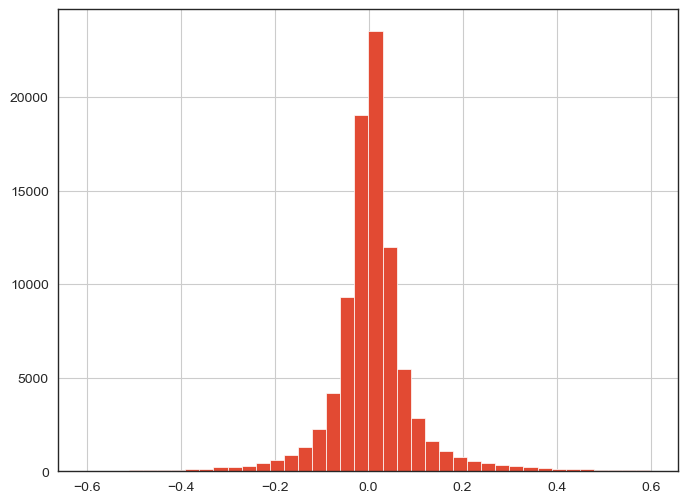

In [6]:
# Look at the distribution of the target variable (log-error)
print(train_2016['logerror'].describe())
train_2016.loc[abs(train_2016['logerror']) < 0.6, 'logerror'].hist(bins=40)

In [7]:
# Looks like there are some outliers in the training data (very large logerror)
# abs(logerror) > 0.6 seems abnormal, should probably remove them from the training set
threshold = 0.6
print("{} training examples in total".format(len(train_2016)))
print("{} with abs(logerror) > {}".format((abs(train_2016['logerror']) > threshold).sum(), threshold))

train_2016 = train_2016[abs(train_2016.logerror) <= threshold]

90275 training examples in total
951 with abs(logerror) > 0.6


In [8]:
# Let's see if there are any feature value outliers -> looks like things are mostly fine, no need to process
prop.describe().loc[['min', 'max', 'mean']].T

,min,max,mean
parcelid,1.071172e+07,1.696019e+08,1.332586e+07
basement_sqft,2.000000e+01,8.516000e+03,6.468833e+02
bathroom_cnt,0.000000e+00,2.000000e+01,2.209143e+00
bedroom_cnt,0.000000e+00,2.000000e+01,3.088949e+00
quality_id,1.000000e+00,1.200000e+01,5.784787e+00
bathroom_cnt_calc,1.000000e+00,2.000000e+01,2.299263e+00
deck_id,6.600000e+01,6.600000e+01,6.600000e+01
floor1_sqft,3.000000e+00,3.130300e+04,1.380660e+03
finished_area_sqft_calc,1.000000e+00,9.525760e+05,1.826764e+03
finished_area_sqft,1.000000e+00,2.903450e+05,1.759635e+03


In [9]:
# Analyze time dependency!
datetime = pd.to_datetime(train_2016.transactiondate).dt
train_2016['month'] = datetime.month
train_2016['quarter'] = datetime.quarter
print(train_2016.groupby('month')['month', 'logerror'].median())
print(train_2016.groupby('quarter')['quarter', 'logerror'].median())

       month  logerror
month                 
1        1.0    0.0090
2        2.0    0.0080
3        3.0    0.0010
4        4.0    0.0030
5        5.0    0.0030
6        6.0    0.0040
7        7.0    0.0050
8        8.0    0.0050
9        9.0    0.0100
10      10.0    0.0100
11      11.0    0.0119
12      12.0    0.0100
         quarter  logerror
quarter                   
1            1.0    0.0050
2            2.0    0.0030
3            3.0    0.0070
4            4.0    0.0109


C:\Users\Zhilin\AppData\Local\Temp\ipykernel_44808\887631847.py:5: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  print(train_2016.groupby('month')['month', 'logerror'].median())
C:\Users\Zhilin\AppData\Local\Temp\ipykernel_44808\887631847.py:6: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  print(train_2016.groupby('quarter')['quarter', 'logerror'].median())


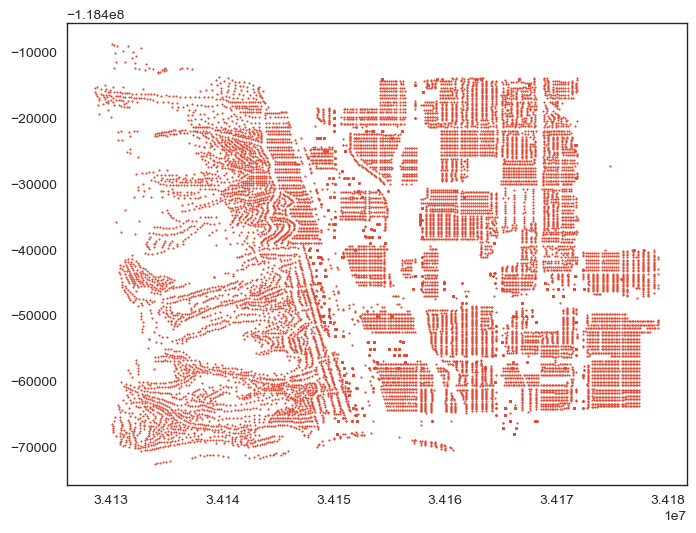

In [10]:
# Let's see how a 'neighborhood' is defined
# Maybe we can extract some neighborhood-based aggregate features
df = prop[prop.neighborhood_id == 27080]
plt.scatter(df.latitude, df.longitude, s=1)

# Data Processing

In [11]:
%%time
# Load in properties data
prop_2016 = data_proc.load_properties_data("data/properties_2016.csv")
prop_2017 = data_proc.load_properties_data("data/properties_2017.csv")

assert len(prop_2016) == len(prop_2017)
print("Number of properties: {}".format(len(prop_2016)))
print("Number of property features: {}".format(len(prop_2016.columns)-1))

Number of properties: 2985217
Number of property features: 57
Wall time: 14.7 s


In [12]:
%%time
# Rename & retype the feature columns; also unify representations of missing values
def get_landuse_code_df(prop_2016, prop_2017):
    temp = prop_2016.groupby('county_landuse_code')['county_landuse_code'].count()
    landuse_codes = list(temp[temp >= 300].index)
    temp = prop_2017.groupby('county_landuse_code')['county_landuse_code'].count()
    landuse_codes += list(temp[temp >= 300].index)
    landuse_codes = list(set(landuse_codes))
    df_landuse_codes = pd.DataFrame({'county_landuse_code': landuse_codes,
                                     'county_landuse_code_id': range(len(landuse_codes))})
    return df_landuse_codes

def get_zoning_desc_code_df(prop_2016, prop_2017):
    temp = prop_2016.groupby('zoning_description')['zoning_description'].count()
    zoning_codes = list(temp[temp >= 5000].index)
    temp = prop_2017.groupby('zoning_description')['zoning_description'].count()
    zoning_codes += list(temp[temp >= 5000].index)
    zoning_codes = list(set(zoning_codes))
    df_zoning_codes = pd.DataFrame({'zoning_description': zoning_codes,
                                     'zoning_description_id': range(len(zoning_codes))})
    return df_zoning_codes

def process_columns(df, df_landuse_codes, df_zoning_codes):
    df = df.merge(how='left', right=df_landuse_codes, on='county_landuse_code')
    df = df.drop(['county_landuse_code'], axis=1)
    
    df = df.merge(how='left', right=df_zoning_codes, on='zoning_description')
    df = df.drop(['zoning_description'], axis=1)
    
    df.loc[df.county_id == 3101, 'county_id'] = 0
    df.loc[df.county_id == 1286, 'county_id'] = 1
    df.loc[df.county_id == 2061, 'county_id'] = 2
    
    df.loc[df.landuse_type_id == 279, 'landuse_type_id'] = 261
    return df

data_proc.rename_columns(prop_2016)
data_proc.rename_columns(prop_2017)

df_landuse_codes = get_landuse_code_df(prop_2016, prop_2017)
df_zoning_codes = get_zoning_desc_code_df(prop_2016, prop_2017)
prop_2016 = process_columns(prop_2016, df_landuse_codes, df_zoning_codes)
prop_2017 = process_columns(prop_2017, df_landuse_codes, df_zoning_codes)

data_proc.retype_columns(prop_2016)
data_proc.retype_columns(prop_2017)

prop_2017.head()

Wall time: 15.4 s


,parcelid,cooling_id,architecture_style_id,basement_sqft,bathroom_cnt,bedroom_cnt,framing_id,quality_id,bathroom_cnt_calc,deck_id,floor1_sqft,finished_area_sqft_calc,finished_area_sqft,perimeter_area,total_area,floor1_sqft_unk,base_total_area,fips,fireplace_cnt,bathroom_full_cnt,garage_cnt,garage_sqft,spa_flag,heating_id,latitude,longitude,lot_sqft,pool_cnt,pool_total_size,pool_unk_1,pool_unk_2,pool_unk_3,landuse_type_id,census_1,city_id,county_id,neighborhood_id,region_zip,room_cnt,story_id,bathroom_small_cnt,construction_id,unit_cnt,patio_sqft,storage_sqft,year_built,story_cnt,fireplace_flag,tax_structure,tax_parcel,tax_year,tax_land,tax_property,tax_overdue_flag,tax_overdue_year,census_2,county_landuse_code_id,zoning_description_id
0,10754147,-1,-1,NaN,0.0,0.0,-1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,NaN,NaN,NaN,NaN,NaN,-1,34144440.0,-118654080.0,85768.0,NaN,NaN,NaN,NaN,NaN,238,60378004.0,37688.0,0,NaN,96337.0,0.0,NaN,NaN,-1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,9.0,2016.0,9.0,NaN,NaN,NaN,NaN,41,-1
1,10759547,-1,-1,NaN,0.0,0.0,-1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,NaN,NaN,NaN,NaN,NaN,-1,34140432.0,-118625360.0,4083.0,NaN,NaN,NaN,NaN,NaN,230,60378000.0,37688.0,0,NaN,96337.0,0.0,NaN,NaN,-1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,27516.0,2015.0,27516.0,NaN,NaN,NaN,NaN,24,53
2,10843547,-1,-1,NaN,0.0,0.0,4,NaN,NaN,NaN,NaN,73026.0,NaN,NaN,73026.0,NaN,NaN,0,NaN,NaN,NaN,NaN,NaN,-1,33989360.0,-118394632.0,63085.0,NaN,NaN,NaN,NaN,NaN,16,60377032.0,51617.0,0,NaN,96095.0,0.0,NaN,NaN,-1,2.0,NaN,NaN,1959.0,1.0,NaN,660680.0,1434941.0,2016.0,774261.0,20800.369141,NaN,NaN,NaN,19,9
3,10859147,-1,-1,NaN,0.0,0.0,2,6.0,NaN,NaN,NaN,5068.0,NaN,NaN,5068.0,NaN,NaN,0,NaN,NaN,NaN,NaN,NaN,-1,34148864.0,-118437208.0,7521.0,NaN,NaN,NaN,NaN,NaN,16,60371412.0,12447.0,0,27080.0,96424.0,0.0,NaN,NaN,-1,NaN,NaN,NaN,1948.0,1.0,NaN,580059.0,1174475.0,2016.0,594416.0,14557.570312,NaN,NaN,NaN,19,9
4,10879947,-1,-1,NaN,0.0,0.0,3,NaN,NaN,NaN,NaN,1776.0,NaN,NaN,1776.0,NaN,NaN,0,NaN,NaN,NaN,NaN,NaN,-1,34194168.0,-118385816.0,8512.0,NaN,NaN,NaN,NaN,NaN,0,60371232.0,12447.0,0,46795.0,96450.0,0.0,NaN,NaN,-1,1.0,NaN,NaN,1947.0,1.0,NaN,196751.0,440101.0,2016.0,243350.0,5725.169922,NaN,NaN,NaN,13,-1


In [13]:
%%time
# Write current DataFrames to hdf5
prop_2016.to_hdf('hdf5/prop.h5', key='prop_2016', format='table', mode='w')
prop_2017.to_hdf('hdf5/prop.h5', key='prop_2017', format='table', mode='a')

Wall time: 4.22 s


In [14]:
%%time
# Read DataFrames from hdf5
prop_2016 = pd.read_hdf('hdf5/prop.h5', 'prop_2016')
prop_2017 = pd.read_hdf('hdf5/prop.h5', 'prop_2017')

Wall time: 3.75 s


In [15]:
# Load in training data (with logerror labels)
train_2016 = data_proc.load_training_data("data/train_2016_v2.csv")
train_2017 = data_proc.load_training_data("data/train_2017.csv")

print("Number of 2016 transaction records: {}".format(len(train_2016)))
print("Number of 2017 transaction records: {}".format(len(train_2017)))
print("\n", train_2016.head())
print("\n", train_2017.head())

Number of 2016 transaction records: 90275
Number of 2017 transaction records: 77613

    parcelid  logerror transactiondate
0  11016594    0.0276      2016-01-01
1  14366692   -0.1684      2016-01-01
2  12098116   -0.0040      2016-01-01
3  12643413    0.0218      2016-01-02
4  14432541   -0.0050      2016-01-02

    parcelid  logerror transactiondate
0  14297519  0.025595      2017-01-01
1  17052889  0.055619      2017-01-01
2  14186244  0.005383      2017-01-01
3  12177905 -0.103410      2017-01-01
4  10887214  0.006940      2017-01-01


# Feature Engineering

In [16]:
# Basic feature engineering + Drop duplicate columns
for prop in [prop_2016, prop_2017]:
    prop['avg_garage_size'] = prop['garage_sqft'] / prop['garage_cnt']
    
    prop['property_tax_per_sqft'] = prop['tax_property'] / prop['finished_area_sqft_calc']
    
    # Rotated Coordinates
    prop['location_1'] = prop['latitude'] + prop['longitude']
    prop['location_2'] = prop['latitude'] - prop['longitude']
    prop['location_3'] = prop['latitude'] + 0.5 * prop['longitude']
    prop['location_4'] = prop['latitude'] - 0.5 * prop['longitude']
    
    # 'finished_area_sqft' and 'total_area' cover only a strict subset of 'finished_area_sqft_calc' in terms of 
    # non-missing values. Also, when both fields are not null, the values are always the same.
    # So we can probably drop 'finished_area_sqft' and 'total_area' since they are redundant
    # If there're some patterns in when the values are missing, we can add two isMissing binary features
    prop['missing_finished_area'] = prop['finished_area_sqft'].isnull().astype(np.float32)
    prop['missing_total_area'] = prop['total_area'].isnull().astype(np.float32)
    prop.drop(['finished_area_sqft', 'total_area'], axis=1, inplace=True)
    
    # Same as above, 'bathroom_cnt' covers everything that 'bathroom_cnt_calc' has
    # So we can safely drop 'bathroom_cnt_calc' and optionally add an isMissing feature
    prop['missing_bathroom_cnt_calc'] = prop['bathroom_cnt_calc'].isnull().astype(np.float32)
    prop.drop(['bathroom_cnt_calc'], axis=1, inplace=True)
    
    # 'room_cnt' has many zero or missing values
    # On the other hand, 'bathroom_cnt' and 'bedroom_cnt' have few zero or missing values
    # Add an derived room_cnt feature by adding bathroom_cnt and bedroom_cnt
    prop['derived_room_cnt'] = prop['bedroom_cnt'] + prop['bathroom_cnt']
    
    # Average area in sqft per room
    mask = (prop.room_cnt >= 1)  # avoid dividing by zero
    prop.loc[mask, 'avg_area_per_room'] = prop.loc[mask, 'finished_area_sqft_calc'] / prop.loc[mask, 'room_cnt']
    
    # Use the derived room_cnt to calculate the avg area again
    mask = (prop.derived_room_cnt >= 1)
    prop.loc[mask,'derived_avg_area_per_room'] = prop.loc[mask,'finished_area_sqft_calc'] / prop.loc[mask,'derived_room_cnt']
    
prop_2017.head()

,parcelid,cooling_id,architecture_style_id,basement_sqft,bathroom_cnt,bedroom_cnt,framing_id,quality_id,deck_id,floor1_sqft,finished_area_sqft_calc,perimeter_area,floor1_sqft_unk,base_total_area,fips,fireplace_cnt,bathroom_full_cnt,garage_cnt,garage_sqft,spa_flag,heating_id,latitude,longitude,lot_sqft,pool_cnt,pool_total_size,pool_unk_1,pool_unk_2,pool_unk_3,landuse_type_id,census_1,city_id,county_id,neighborhood_id,region_zip,room_cnt,story_id,bathroom_small_cnt,construction_id,unit_cnt,patio_sqft,storage_sqft,year_built,story_cnt,fireplace_flag,tax_structure,tax_parcel,tax_year,tax_land,tax_property,tax_overdue_flag,tax_overdue_year,census_2,county_landuse_code_id,zoning_description_id,avg_garage_size,property_tax_per_sqft,location_1,location_2,location_3,location_4,missing_finished_area,missing_total_area,missing_bathroom_cnt_calc,derived_room_cnt,avg_area_per_room,derived_avg_area_per_room
0,10754147,-1,-1,NaN,0.0,0.0,-1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,NaN,NaN,NaN,NaN,NaN,-1,34144440.0,-118654080.0,85768.0,NaN,NaN,NaN,NaN,NaN,238,60378004.0,37688.0,0,NaN,96337.0,0.0,NaN,NaN,-1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,9.0,2016.0,9.0,NaN,NaN,NaN,NaN,41,-1,NaN,NaN,-84509640.0,152798528.0,-25182600.0,93471480.0,1.0,1.0,1.0,0.0,NaN,NaN
1,10759547,-1,-1,NaN,0.0,0.0,-1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,NaN,NaN,NaN,NaN,NaN,-1,34140432.0,-118625360.0,4083.0,NaN,NaN,NaN,NaN,NaN,230,60378000.0,37688.0,0,NaN,96337.0,0.0,NaN,NaN,-1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,27516.0,2015.0,27516.0,NaN,NaN,NaN,NaN,24,53,NaN,NaN,-84484928.0,152765792.0,-25172248.0,93453112.0,1.0,1.0,1.0,0.0,NaN,NaN
2,10843547,-1,-1,NaN,0.0,0.0,4,NaN,NaN,NaN,73026.0,NaN,NaN,NaN,0,NaN,NaN,NaN,NaN,NaN,-1,33989360.0,-118394632.0,63085.0,NaN,NaN,NaN,NaN,NaN,16,60377032.0,51617.0,0,NaN,96095.0,0.0,NaN,NaN,-1,2.0,NaN,NaN,1959.0,1.0,NaN,660680.0,1434941.0,2016.0,774261.0,20800.369141,NaN,NaN,NaN,19,9,NaN,0.284835,-84405272.0,152384000.0,-25207956.0,93186676.0,1.0,0.0,1.0,0.0,NaN,NaN
3,10859147,-1,-1,NaN,0.0,0.0,2,6.0,NaN,NaN,5068.0,NaN,NaN,NaN,0,NaN,NaN,NaN,NaN,NaN,-1,34148864.0,-118437208.0,7521.0,NaN,NaN,NaN,NaN,NaN,16,60371412.0,12447.0,0,27080.0,96424.0,0.0,NaN,NaN,-1,NaN,NaN,NaN,1948.0,1.0,NaN,580059.0,1174475.0,2016.0,594416.0,14557.570312,NaN,NaN,NaN,19,9,NaN,2.872449,-84288344.0,152586080.0,-25069740.0,93367468.0,1.0,0.0,1.0,0.0,NaN,NaN
4,10879947,-1,-1,NaN,0.0,0.0,3,NaN,NaN,NaN,1776.0,NaN,NaN,NaN,0,NaN,NaN,NaN,NaN,NaN,-1,34194168.0,-118385816.0,8512.0,NaN,NaN,NaN,NaN,NaN,0,60371232.0,12447.0,0,46795.0,96450.0,0.0,NaN,NaN,-1,1.0,NaN,NaN,1947.0,1.0,NaN,196751.0,440101.0,2016.0,243350.0,5725.169922,NaN,NaN,NaN,13,-1,NaN,3.223632,-84191648.0,152579984.0,-24998740.0,93387076.0,1.0,0.0,1.0,0.0,NaN,NaN


In [17]:
# Compute region-based aggregate features
def add_aggregate_features(df, group_col, agg_cols):
    df[group_col + '-groupcnt'] = df[group_col].map(df[group_col].value_counts())
    new_columns = []  # New feature columns added to the DataFrame

    for col in agg_cols:
        aggregates = df.groupby(group_col, as_index=False)[col].agg([np.mean])
        aggregates.columns = [group_col + '-' + col + '-' + s for s in ['mean']]
        new_columns += list(aggregates.columns)
        df = df.merge(how='left', right=aggregates, on=group_col)
        
    for col in agg_cols:
        mean = df[group_col + '-' + col + '-mean']
        diff = df[col] - mean
        
        df[group_col + '-' + col + '-' + 'diff'] = diff
        if col != 'year_built':
            df[group_col + '-' + col + '-' + 'percent'] = diff / mean
        
    # Set the values of the new features to NaN if the groupcnt is too small (prevent overfitting)
    threshold = 100
    df.loc[df[group_col + '-groupcnt'] < threshold, new_columns] = np.nan
    
    # Drop the mean features since they turn out to be not useful
    df.drop([group_col+'-'+col+'-mean' for col in agg_cols], axis=1, inplace=True)
    
    gc.collect()
    return df

group_col = 'region_zip'
agg_cols = ['lot_sqft', 'year_built', 'finished_area_sqft_calc',
            'tax_structure', 'tax_land', 'tax_property', 'property_tax_per_sqft']
prop_2016 = add_aggregate_features(prop_2016, group_col, agg_cols)
prop_2017 = add_aggregate_features(prop_2017, group_col, agg_cols)

prop_2017.head(10)

,parcelid,cooling_id,architecture_style_id,basement_sqft,bathroom_cnt,bedroom_cnt,framing_id,quality_id,deck_id,floor1_sqft,finished_area_sqft_calc,perimeter_area,floor1_sqft_unk,base_total_area,fips,fireplace_cnt,bathroom_full_cnt,garage_cnt,garage_sqft,spa_flag,heating_id,latitude,longitude,lot_sqft,pool_cnt,pool_total_size,pool_unk_1,pool_unk_2,pool_unk_3,landuse_type_id,census_1,city_id,county_id,neighborhood_id,region_zip,room_cnt,story_id,bathroom_small_cnt,construction_id,unit_cnt,patio_sqft,storage_sqft,year_built,story_cnt,fireplace_flag,tax_structure,tax_parcel,tax_year,tax_land,tax_property,tax_overdue_flag,tax_overdue_year,census_2,county_landuse_code_id,zoning_description_id,avg_garage_size,property_tax_per_sqft,location_1,location_2,location_3,location_4,missing_finished_area,missing_total_area,missing_bathroom_cnt_calc,derived_room_cnt,avg_area_per_room,derived_avg_area_per_room,region_zip-groupcnt,region_zip-lot_sqft-diff,region_zip-lot_sqft-percent,region_zip-year_built-diff,region_zip-finished_area_sqft_calc-diff,region_zip-finished_area_sqft_calc-percent,region_zip-tax_structure-diff,region_zip-tax_structure-percent,region_zip-tax_land-diff,region_zip-tax_land-percent,region_zip-tax_property-diff,region_zip-tax_property-percent,region_zip-property_tax_per_sqft-diff,region_zip-property_tax_per_sqft-percent
0,10754147,-1,-1,NaN,0.0,0.0,-1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,NaN,NaN,NaN,NaN,NaN,-1,34144440.0,-118654080.0,85768.0,NaN,NaN,NaN,NaN,NaN,238,60378004.0,37688.0,0,NaN,96337.0,0.0,NaN,NaN,-1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,9.0,2016.0,9.0,NaN,NaN,NaN,NaN,41,-1,NaN,NaN,-84509640.0,152798528.0,-25182600.0,93471480.0,1.0,1.0,1.0,0.0,NaN,NaN,8496.0,25030.929688,0.412119,NaN,NaN,NaN,NaN,NaN,-551431.062500,-0.999984,NaN,NaN,NaN,NaN
1,10759547,-1,-1,NaN,0.0,0.0,-1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,NaN,NaN,NaN,NaN,NaN,-1,34140432.0,-118625360.0,4083.0,NaN,NaN,NaN,NaN,NaN,230,60378000.0,37688.0,0,NaN,96337.0,0.0,NaN,NaN,-1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,27516.0,2015.0,27516.0,NaN,NaN,NaN,NaN,24,53,NaN,NaN,-84484928.0,152765792.0,-25172248.0,93453112.0,1.0,1.0,1.0,0.0,NaN,NaN,8496.0,-56654.070312,-0.932776,NaN,NaN,NaN,NaN,NaN,-523924.062500,-0.950102,NaN,NaN,NaN,NaN
2,10843547,-1,-1,NaN,0.0,0.0,4,NaN,NaN,NaN,73026.0,NaN,NaN,NaN,0,NaN,NaN,NaN,NaN,NaN,-1,33989360.0,-118394632.0,63085.0,NaN,NaN,NaN,NaN,NaN,16,60377032.0,51617.0,0,NaN,96095.0,0.0,NaN,NaN,-1,2.0,NaN,NaN,1959.0,1.0,NaN,660680.0,1434941.0,2016.0,774261.0,20800.369141,NaN,NaN,NaN,19,9,NaN,0.284835,-84405272.0,152384000.0,-25207956.0,93186676.0,1.0,0.0,1.0,0.0,NaN,NaN,9439.0,-19054.117188,-0.231974,-1.895996,71617.218750,50.836166,521561.343750,3.749040,529789.687500,2.167083,15996.112305,3.329571,-3.279059,-0.920078
3,10859147,-1,-1,NaN,0.0,0.0,2,6.0,NaN,NaN,5068.0,NaN,NaN,NaN,0,NaN,NaN,NaN,NaN,NaN,-1,34148864.0,-118437208.0,7521.0,NaN,NaN,NaN,NaN,NaN,16,60371412.0,12447.0,0,27080.0,96424.0,0.0,NaN,NaN,-1,NaN,NaN,NaN,1948.0,1.0,NaN,580059.0,1174475.0,2016.0,594416.0,14557.570312,NaN,NaN,NaN,19,9,NaN,2.872449,-84288344.0,152586080.0,-25069740.0,93367468.0,1.0,0.0,1.0,0.0,NaN,NaN,7912.0,-8604.140625,-0.533585,-13.133911,3026.638672,1.482657,327684.281250,1.298404,228256.031250,0.623378,7026.920410,0.933109,-0.825856,-0.223307
4,10879947,-1,-1,NaN,0.0,0.0,3,NaN,NaN,NaN,1776.0,NaN,NaN,NaN,0,NaN,NaN,NaN,NaN,NaN,-1,34194168.0,-118385816.0,8512.0,NaN,NaN,NaN,NaN,NaN,0,60371232.0,12447.0,0,46795.0,96450.0,0.0,NaN,NaN,-1,1.0,NaN,NaN,1947.0,1.0,NaN,196751.0,440101.0,2016.0,243350.0,5725.169922,NaN,NaN,NaN,13,-1,NaN,3.223632,-84191648.0,152579984.0,-24998740.0,93387076.0,1.0,0.0,1.0,0.0,NaN,NaN,7726.0,-10369.894531,-0.549198,-10.163208,205.602173,0.130924,63124.031250,0.472390,87361.265625,0.560049,2136.794189,0.595477,0.814859,0.338288
5,10898347,-1,-1,NaN,0.0,0.0,3,4.0,NaN,NaN,2400.0,NaN,NaN,NaN,0,NaN,NaN,NaN,NaN,NaN,-1,34171872.0,-118380904.0,2500.0,NaN,NaN,NaN,NaN,NaN,0,60371252.0,12447.0,0,46795.0,96446.0,0.0,NaN,NaN,-1,NaN,NaN,NaN,1943.0,1.0,NaN,179072.0,287634.0,2016.0,108562

In [18]:
%%time
# Write feature DataFrames to hdf5
prop_2016.to_hdf('hdf5/features.h5', key='features_2016', format='table', mode='w')
prop_2017.to_hdf('hdf5/features.h5', key='features_2017', format='table', mode='a')

Wall time: 5.35 s


In [19]:
# Join the training data with the property table
train_2016 = train_2016.merge(how='left', right=prop_2016, on='parcelid')
train_2017 = train_2017.merge(how='left', right=prop_2017, on='parcelid')
train = pd.concat([train_2016, train_2017], axis=0, ignore_index=True)

# Combine the 2016 and 2017 training sets
train = pd.concat([train_2016, train_2017], axis=0, ignore_index=True)
print("\nCombined training set size: {}".format(len(train)))

# Add datetime features to training data
data_proc.add_simple_datetime_features(train)

train.head(10)


Combined training set size: 167888


,parcelid,logerror,cooling_id,architecture_style_id,basement_sqft,bathroom_cnt,bedroom_cnt,framing_id,quality_id,deck_id,floor1_sqft,finished_area_sqft_calc,perimeter_area,floor1_sqft_unk,base_total_area,fips,fireplace_cnt,bathroom_full_cnt,garage_cnt,garage_sqft,spa_flag,heating_id,latitude,longitude,lot_sqft,pool_cnt,pool_total_size,pool_unk_1,pool_unk_2,pool_unk_3,landuse_type_id,census_1,city_id,county_id,neighborhood_id,region_zip,room_cnt,story_id,bathroom_small_cnt,construction_id,unit_cnt,patio_sqft,storage_sqft,year_built,story_cnt,fireplace_flag,tax_structure,tax_parcel,tax_year,tax_land,tax_property,tax_overdue_flag,tax_overdue_year,census_2,county_landuse_code_id,zoning_description_id,avg_garage_size,property_tax_per_sqft,location_1,location_2,location_3,location_4,missing_finished_area,missing_total_area,missing_bathroom_cnt_calc,derived_room_cnt,avg_area_per_room,derived_avg_area_per_room,region_zip-groupcnt,region_zip-lot_sqft-diff,region_zip-lot_sqft-percent,region_zip-year_built-diff,region_zip-finished_area_sqft_calc-diff,region_zip-finished_area_sqft_calc-percent,region_zip-tax_structure-diff,region_zip-tax_structure-percent,region_zip-tax_land-diff,region_zip-tax_land-percent,region_zip-tax_property-diff,region_zip-tax_property-percent,region_zip-property_tax_per_sqft-diff,region_zip-property_tax_per_sqft-percent,year,month,quarter
0,11016594,0.0276,0,-1,NaN,2.0,3.0,-1,4.0,NaN,NaN,1684.0,NaN,NaN,NaN,0,NaN,2.0,NaN,NaN,NaN,1,34280992.0,-118488536.0,7528.0,NaN,NaN,NaN,NaN,NaN,230,60371068.0,12447.0,0,31817.0,96370.0,0.0,NaN,NaN,-1,1.0,NaN,NaN,1959.0,NaN,NaN,122754.0,360170.0,2015.0,237416.0,6735.879883,NaN,NaN,6.037107e+13,31,23,NaN,3.999929,-84207544.0,152769536.0,-24963276.0,93525260.0,0.0,1.0,0.0,5.0,NaN,336.799988,14719.0,-13398.968750,-0.640273,-3.998413,-247.725464,-0.128241,-50475.015625,-0.291377,5.102642e+04,0.273762,2047.035645,0.436576,1.521634,0.613984,0,1,1
1,14366692,-0.1684,-1,-1,NaN,3.5,4.0,-1,NaN,NaN,NaN,2263.0,NaN,NaN,NaN,22,NaN,3.0,2.0,468.0,NaN,-1,33668120.0,-117677552.0,3643.0,NaN,NaN,NaN,NaN,NaN,230,60590524.0,32380.0,1,NaN,96962.0,0.0,NaN,1.0,-1,NaN,NaN,NaN,2014.0,NaN,NaN,346458.0,585529.0,2015.0,239071.0,10153.019531,NaN,NaN,NaN,30,-1,234.0,4.486531,-84009432.0,151345664.0,-25170656.0,92506896.0,0.0,1.0,0.0,7.5,NaN,301.733337,17682.0,-2715.032715,-0.427024,35.535156,526.538208,0.303225,213678.171875,1.609267,1.630267e+04,0.073182,6339.847656,1.662618,2.160548,0.928875,0,1,1
2,12098116,-0.0040,0,-1,NaN,3.0,2.0,-1,4.0,NaN,NaN,2217.0,NaN,NaN,NaN,0,NaN,3.0,NaN,NaN,NaN,1,34136312.0,-118175032.0,11423.0,NaN,NaN,NaN,NaN,NaN,230,60374640.0,47019.0,0,275411.0,96293.0,0.0,NaN,NaN,-1,1.0,NaN,NaN,1940.0,NaN,NaN,61994.0,119906.0,2015.0,57912.0,11484.480469,NaN,NaN,6.037464e+13,31,40,NaN,5.180190,-84038720.0,152311344.0,-24951204.0,93223828.0,0.0,1.0,0.0,5.0,NaN,443.399994,4422.0,-14927.021484,-0.566490,-12.917847,-173.867432,-0.072721,-236757.281250,-0.792490,-4.276051e+05,-0.880721,1845.573242,0.191471,1.178391,0.294465,0,1,1
3,12643413,0.0218,0,-1,NaN,2.0,2.0,-1,4.0,NaN,NaN,839.0,NaN,NaN,NaN,0,NaN,2.0,NaN,NaN,NaN,1,33755800.0,-118309000.0,70859.0,NaN,NaN,NaN,NaN,NaN,235,60372964.0,12447.0,0,54300.0,96222.0,0.0,NaN,NaN,-1,1.0,NaN,NaN,1987.0,NaN,NaN,171518.0,244880.0,2015.0,73362.0,3048.739990,NaN,NaN,6.037296e+13,5,36,NaN,3.633778,-84553200.0,152064800.0,-25398700.0,92910300.0,0.0,1.0,0.0,4.0,NaN,209.750000,7293.0,-43346.804688,-0.379550,21.690186,-782.150757,-0.482466,30903.765625,0.219777,-1.294408e+05,-0.638259,-1337.844971,-0.304986,0.830251,0.296145,0,1,1
4,14432541,-0.0050,-1,-1,NaN,2.5,4.0,-1,NaN,NaN,NaN,2283.0,NaN,NaN,NaN,22,NaN,2.0,2.0,598.0,NaN,-1,33485644.0,-117700232.0,6000.0,1.0,NaN,NaN,NaN,1.0,230,60590424.0,17686.0,1,NaN,96961.0,8.0,NaN,1.0,-1,NaN,NaN,NaN,1981.0,2.0,NaN,169574.0,434551.0,2015.0,264977.0,5488.959961,NaN,NaN,6.059042e+13,36,-1,299.0,2.404275,-84214592.0,151185872.0,-25364472.0,92335760.0,0.0,1.0,0.0,6.5,285.375000,351.230774,9875.0,-1155.377441,-0.161470,0.695679,244.8

In [20]:
%%time
# Write training DataFrame to hdf5
train.to_hdf('hdf5/train.h5', key='train', format='table', mode='w')

Wall time: 278 ms


# Catboost Model

In [21]:
# Save CatBoost models to files
def save_models(models):
    for i, model in enumerate(models):
        model.save_model('checkpoints/catboost_' + str(i))
    print("Saved {} CatBoost models to files.".format(len(models)))

# Load CatBoost models from files
def load_models(paths):
    models = []
    for path in paths:
        model = CatBoostRegressor()
        model.load_model(path)
        models.append(model)
    return models

In [22]:
"""
    Drop id and label columns + Feature selection for CatBoost
"""
def catboost_drop_features(features):
    # id and label (not features)
    unused_feature_list = ['parcelid', 'logerror']

    # too many missing
    missing_list = ['framing_id', 'architecture_style_id', 'story_id', 'perimeter_area', 'basement_sqft', 'storage_sqft']
    unused_feature_list += missing_list

    # not useful
    bad_feature_list = ['fireplace_flag', 'deck_id', 'pool_unk_1', 'construction_id', 'fips', 'county_id']
    unused_feature_list += bad_feature_list

    # hurts performance
    unused_feature_list += ['county_landuse_code_id', 'zoning_description_id']

    return features.drop(unused_feature_list, axis=1, errors='ignore')

In [23]:
%%time
# Read DataFrames from hdf5
features_2016 = pd.read_hdf('hdf5/features.h5', 'features_2016')  # All features except for datetime for 2016
features_2017 = pd.read_hdf('hdf5/features.h5', 'features_2017')  # All features except for datetime for 2017
train = pd.read_hdf('hdf5/train.h5', 'train')  # Concatenated 2016 and 2017 training data with labels

Wall time: 5.74 s


In [36]:
catboost_features = catboost_drop_features(train)
print("Number of features for CatBoost: {}".format(len(catboost_features.columns)))
catboost_features.head(5)

Number of features for CatBoost: 69


,cooling_id,bathroom_cnt,bedroom_cnt,quality_id,floor1_sqft,finished_area_sqft_calc,floor1_sqft_unk,base_total_area,fireplace_cnt,bathroom_full_cnt,garage_cnt,garage_sqft,spa_flag,heating_id,latitude,longitude,lot_sqft,pool_cnt,pool_total_size,pool_unk_2,pool_unk_3,landuse_type_id,census_1,city_id,neighborhood_id,region_zip,room_cnt,bathroom_small_cnt,unit_cnt,patio_sqft,year_built,story_cnt,tax_structure,tax_parcel,tax_year,tax_land,tax_property,tax_overdue_flag,tax_overdue_year,census_2,avg_garage_size,property_tax_per_sqft,location_1,location_2,location_3,location_4,missing_finished_area,missing_total_area,missing_bathroom_cnt_calc,derived_room_cnt,avg_area_per_room,derived_avg_area_per_room,region_zip-groupcnt,region_zip-lot_sqft-diff,region_zip-lot_sqft-percent,region_zip-year_built-diff,region_zip-finished_area_sqft_calc-diff,region_zip-finished_area_sqft_calc-percent,region_zip-tax_structure-diff,region_zip-tax_structure-percent,region_zip-tax_land-diff,region_zip-tax_land-percent,region_zip-tax_property-diff,region_zip-tax_property-percent,region_zip-property_tax_per_sqft-diff,region_zip-property_tax_per_sqft-percent,year,month,quarter
0,0,2.0,3.0,4.0,NaN,1684.0,NaN,NaN,NaN,2.0,NaN,NaN,NaN,1,34280992.0,-118488536.0,7528.0,NaN,NaN,NaN,NaN,230,60371068.0,12447.0,31817.0,96370.0,0.0,NaN,1.0,NaN,1959.0,NaN,122754.0,360170.0,2015.0,237416.0,6735.879883,NaN,NaN,6.037107e+13,NaN,3.999929,-84207544.0,152769536.0,-24963276.0,93525260.0,0.0,1.0,0.0,5.0,NaN,336.799988,14719.0,-13398.968750,-0.640273,-3.998413,-247.725464,-0.128241,-50475.015625,-0.291377,51026.421875,0.273762,2047.035645,0.436576,1.521634,0.613984,0,1,1
1,-1,3.5,4.0,NaN,NaN,2263.0,NaN,NaN,NaN,3.0,2.0,468.0,NaN,-1,33668120.0,-117677552.0,3643.0,NaN,NaN,NaN,NaN,230,60590524.0,32380.0,NaN,96962.0,0.0,1.0,NaN,NaN,2014.0,NaN,346458.0,585529.0,2015.0,239071.0,10153.019531,NaN,NaN,NaN,234.0,4.486531,-84009432.0,151345664.0,-25170656.0,92506896.0,0.0,1.0,0.0,7.5,NaN,301.733337,17682.0,-2715.032715,-0.427024,35.535156,526.538208,0.303225,213678.171875,1.609267,16302.671875,0.073182,6339.847656,1.662618,2.160548,0.928875,0,1,1
2,0,3.0,2.0,4.0,NaN,2217.0,NaN,NaN,NaN,3.0,NaN,NaN,NaN,1,34136312.0,-118175032.0,11423.0,NaN,NaN,NaN,NaN,230,60374640.0,47019.0,275411.0,96293.0,0.0,NaN,1.0,NaN,1940.0,NaN,61994.0,119906.0,2015.0,57912.0,11484.480469,NaN,NaN,6.037464e+13,NaN,5.180190,-84038720.0,152311344.0,-24951204.0,93223828.0,0.0,1.0,0.0,5.0,NaN,443.399994,4422.0,-14927.021484,-0.566490,-12.917847,-173.867432,-0.072721,-236757.281250,-0.792490,-427605.093750,-0.880721,1845.573242,0.191471,1.178391,0.294465,0,1,1
3,0,2.0,2.0,4.0,NaN,839.0,NaN,NaN,NaN,2.0,NaN,NaN,NaN,1,33755800.0,-118309000.0,70859.0,NaN,NaN,NaN,NaN,235,60372964.0,12447.0,54300.0,96222.0,0.0,NaN,1.0,NaN,1987.0,NaN,171518.0,244880.0,2015.0,73362.0,3048.739990,NaN,NaN,6.037296e+13,NaN,3.633778,-84553200.0,152064800.0,-25398700.0,92910300.0,0.0,1.0,0.0,4.0,NaN,209.750000,7293.0,-43346.804688,-0.379550,21.690186,-782.150757,-0.482466,30903.765625,0.219777,-129440.812500,-0.638259,-1337.844971,-0.304986,0.830251,0.296145,0,1,1
4,-1,2.5,4.0,NaN,NaN,2283.0,NaN,NaN,NaN,2.0,2.0,598.0,NaN,-1,33485644.0,-117700232.0,6000.0,1.0,NaN,NaN,1.0,230,60590424.0,17686.0,NaN,96961.0,8.0,1.0,NaN,NaN,1981.0,2.0,169574.0,434551.0,2015.0,264977.0,5488.959961,NaN,NaN,6.059042e+13,299.0,2.404275,-84214592.0,151185872.0,-25364472.0,92335760.0,0.0,1.0,0.0,6.5,285.375,351.230774,9875.0,-1155.377441,-0.161470,0.695679,244.801147,0.120107,-50359.125000,-0.228975,-195977.250000,-0.425156,-2742.872070,-0.333203,-1.339566,-0.357805,0,1,1


In [39]:
catboost_label = train['logerror'].astype(np.float32)

# Perform shuffled train/test split
np.random.seed(42)
random.seed(10)
X_train, X_val, y_train, y_val = train_test_split(catboost_features, catboost_label, test_size=0.2)

# Remove outlier examples from X_train and y_train; Keep them in X_val and y_val for proper cross-validation
outlier_threshold = 0.4
mask = (abs(y_train) <= outlier_threshold)
X_train = X_train[mask]
y_train = y_train[mask]

print("X_train shape: {}".format(X_train.shape))
print("y_train shape: {}".format(y_train.shape))
print("X_val shape: {}".format(X_val.shape))
print("y_val shape: {}".format(y_val.shape))

X_train shape: (131426, 69)
y_train shape: (131426,)
X_val shape: (33578, 69)
y_val shape: (33578,)


In [40]:
# Specify feature names and categorical features for CatBoost
feature_names = [s for s in catboost_features.columns]
categorical_features = ['cooling_id', 'heating_id', 'landuse_type_id', 'year', 'month', 'quarter']

categorical_indices = []
for i, n in enumerate(catboost_features.columns):
    if n in categorical_features:
        categorical_indices.append(i)
print(categorical_indices)

[0, 13, 21, 66, 67, 68]


In [41]:
# CatBoost parameters
params = {}
params['loss_function'] = 'MAE'
params['eval_metric'] = 'MAE'
params['nan_mode'] = 'Min'  # Method to handle NaN (set NaN to either Min or Max)
params['random_seed'] = 0

params['iterations'] = 1000  # default 1000, use early stopping during training
params['learning_rate'] = 0.015  # default 0.03

params['border_count'] = 254  # default 254 (alias max_bin, suggested to keep at default for best quality)

params['max_depth'] = 6  # default 6 (must be <= 16, 6 to 10 is recommended)
params['random_strength'] = 1  # default 1 (used during splitting to deal with overfitting, try different values)
params['l2_leaf_reg'] = 5  # default 3 (used for leaf value calculation, try different values)
params['bagging_temperature'] = 1  # default 1 (higher value -> more aggressive bagging, try different values)

In [42]:
# Train CatBoost Regressor with cross-validated early-stopping
val_pool = Pool(data = X_val, label=y_val, cat_features=categorical_indices)

np.random.seed(42)
random.seed(36)
model = CatBoostRegressor(**params)
model.fit(X_train, y_train,
          cat_features=categorical_indices,
          use_best_model=True, eval_set=val_pool, early_stopping_rounds=50, verbose=False)

# Evaluate model performance
print("Train score: {}".format(abs(model.predict(X_train) - y_train).mean() * 100))
print("Val score: {}".format(abs(model.predict(X_val) - y_val).mean() * 100))

Train score: 5.123209887878563
Val score: 6.866892964119739


In [43]:
# CatBoost feature importance
feature_importance = [(feature_names[i], value) for i, value in enumerate(model.get_feature_importance())]
feature_importance.sort(key=lambda x: x[1], reverse=True)
for k, v in feature_importance[:10]:
    print("{}: {}".format(k, v))

finished_area_sqft_calc: 4.553907262042962
month: 3.8676513769983405
lot_sqft: 3.584889211738132
region_zip-tax_property-percent: 3.4565523304814803
year_built: 3.225316023129428
pool_cnt: 3.0862214298097976
region_zip-tax_land-percent: 3.063061289194192
region_zip-finished_area_sqft_calc-percent: 2.956714701792523
location_1: 2.819368533375387
region_zip-property_tax_per_sqft-diff: 2.7473716214309873


In [44]:
params['random_seed'] = 0
params['iterations'] = 1000  # roughly chosen based on public leaderboard score
print(params)
np.random.seed(42)
random.seed(36)
model = CatBoostRegressor(**params)
model.fit(catboost_features, catboost_label, cat_features=categorical_indices, verbose=False)

{'loss_function': 'MAE', 'eval_metric': 'MAE', 'nan_mode': 'Min', 'random_seed': 0, 'iterations': 1000, 'learning_rate': 0.015, 'border_count': 254, 'max_depth': 6, 'random_strength': 1, 'l2_leaf_reg': 5, 'bagging_temperature': 1}


In [45]:
# Sanity check: score on a small portion of the dataset
print("sanity check score: {}".format(abs(model.predict(catboost_features) - catboost_label).mean() * 100))

sanity check score: 6.753739974104883


In [46]:
"""
    Helper method that prepares 2016 and 2017 properties features for CatBoost inference
"""
def transform_test_features(features_2016, features_2017):
    test_features_2016 = catboost_drop_features(features_2016)
    test_features_2017 = catboost_drop_features(features_2017)
    
    test_features_2016['year'] = 0
    test_features_2017['year'] = 1
    
    # 11 and 12 lead to bad results, probably due to the fact that there aren't many training examples for those two
    test_features_2016['month'] = 10
    test_features_2017['month'] = 10
    
    test_features_2016['quarter'] = 4
    test_features_2017['quarter'] = 4
    
    return test_features_2016, test_features_2017

"""
    Helper method that makes predictions on the test set and exports results to csv file
    'models' is a list of models for ensemble prediction (len=1 means using just a single model)
"""
def predict_and_export(models, features_2016, features_2017, file_name):
    # Construct DataFrame for prediction results
    submission_2016 = pd.DataFrame()
    submission_2017 = pd.DataFrame()
    submission_2016['ParcelId'] = features_2016.parcelid
    submission_2017['ParcelId'] = features_2017.parcelid
    
    test_features_2016, test_features_2017 = transform_test_features(features_2016, features_2017)
    
    pred_2016, pred_2017 = [], []
    for i, model in enumerate(models):
        print("Start model {} (2016)".format(i))
        pred_2016.append(model.predict(test_features_2016))
        print("Start model {} (2017)".format(i))
        pred_2017.append(model.predict(test_features_2017))
    
    # Take average across all models
    mean_pred_2016 = np.mean(pred_2016, axis=0)
    mean_pred_2017 = np.mean(pred_2017, axis=0)
    
    submission_2016['201610'] = [float(format(x, '.4f')) for x in mean_pred_2016]
    submission_2016['201611'] = submission_2016['201610']
    submission_2016['201612'] = submission_2016['201610']

    submission_2017['201710'] = [float(format(x, '.4f')) for x in mean_pred_2017]
    submission_2017['201711'] = submission_2017['201710']
    submission_2017['201712'] = submission_2017['201710']
    
    submission = submission_2016.merge(how='inner', right=submission_2017, on='ParcelId')
    
    print("Length of submission DataFrame: {}".format(len(submission)))
    print("Submission header:")
    print(submission.head())
    submission.to_csv(file_name, index=False)
    return submission, pred_2016, pred_2017 

In [47]:
file_name = 'final_catboost_single.csv'
submission, pred_2016, pred_2017 = predict_and_export([model], features_2016, features_2017, file_name)

Start model 0 (2016)
Start model 0 (2017)
Length of submission DataFrame: 2985217
Submission header:
   ParcelId  201610  201611  201612  201710  201711  201712
0  10754147  0.0470  0.0470  0.0470  0.0480  0.0480  0.0480
1  10759547  0.0099  0.0099  0.0099  0.0153  0.0153  0.0153
2  10843547  0.0485  0.0485  0.0485  0.0672  0.0672  0.0672
3  10859147  0.0234  0.0234  0.0234  0.0236  0.0236  0.0236
4  10879947  0.0066  0.0066  0.0066  0.0079  0.0079  0.0079
